In [ ]:
# Deep Learning CEP Project - Chest X-ray Pneumonia Classification
# Dataset: Chest X-ray Pneumonia (Kaggle)
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Dropout,GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Mount Kaggle and download dataset automatically
!pip install -q kaggle
import json
from google.colab import files


In [ ]:
# Upload kaggle.json (Kaggle API key)
uploaded = files.upload()
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "wb") as f: f.write(uploaded['kaggle.json'])
os.chmod("/root/.kaggle/kaggle.json", 0o600)

Saving kaggle.json to kaggle.json


In [ ]:
# Download Chest X-ray dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 96% 2.20G/2.29G [00:18<00:02, 46.5MB/s]
100% 2.29G/2.29G [00:18<00:00, 131MB/s] 


In [ ]:
# Phase 1: Dataset Selection and Preprocessing
img_height, img_width = 299, 299
batch_size = 16
dataset_path = '/content/chest_xray'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

In [ ]:
# Generic data preprocessing
datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.2,
horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(train_dir, target_size=(img_height, img_width),
batch_size=batch_size, class_mode='binary')
val_data = test_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width),
batch_size=batch_size, class_mode='binary')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width),
batch_size=batch_size, class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Compute class weights
from sklearn.utils import class_weight
labels = train_data.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [ ]:
# Build CNN model
cnn_model = models.Sequential([
layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
layers.MaxPooling2D(),
layers.Dropout(0.15),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D(),
layers.Dropout(0.25),
layers.Conv2D(128, (3, 3), activation='relu'),
layers.MaxPooling2D(),
layers.Dropout(0.4),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dropout(0.5),
layers.Dense(1, activation='sigmoid')])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train CNN
cnn_history = cnn_model.fit(
train_data,
epochs=10,
validation_data=val_data,
callbacks=[early_stop, reduce_lr],
class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 152s 436ms/step - accuracy: 0.6755 - loss: 0.8177 - val_accuracy: 0.7500 - val_loss: 0.4798 - learning_rate: 0.0010
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 142s 437ms/step - accuracy: 0.8587 - loss: 0.3591 - val_accuracy: 0.9375 - val_loss: 0.3903 - learning_rate: 0.0010
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 144s 440ms/step - accuracy: 0.8958 - loss: 0.2548 - val_accuracy: 0.6875 - val_loss: 0.5730 - learning_rate: 0.0010
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 143s 437ms/step - accuracy: 0.9051 - loss: 0.2450 - val_accuracy: 0.6875 - val_loss: 0.5568 - learning_rate: 0.0010
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.9102 - loss: 0.2246 - val_accuracy: 0.6875 - val_loss: 0.6211 - learning_rate: 2.0000e-04


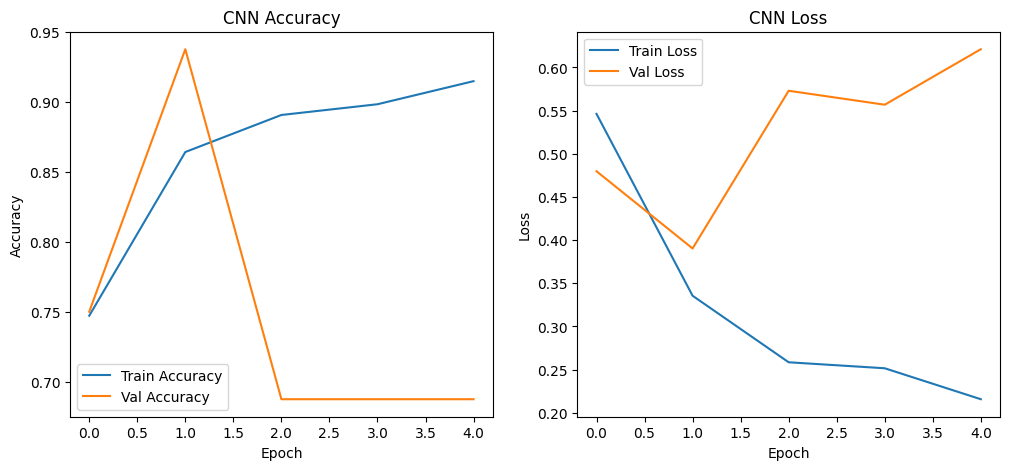

In [ ]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(cnn_history, "CNN")

In [ ]:
# Evaluate CNN model
def evaluate_model(model, test_data, name):
    print(f"\nEvaluating {name} on test data:")
    loss, acc = model.evaluate(test_data)
    print(f"Test Accuracy: {acc:.4f}")

    y_pred = (model.predict(test_data) > 0.5).astype(int).reshape(-1)
    y_true = test_data.classes
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

evaluate_model(cnn_model, test_data, "CNN")


Evaluating CNN on test data:
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.7199 - loss: 0.5230
Test Accuracy: 0.8301
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step

Confusion Matrix:
[[162  72]
 [ 34 356]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.83      0.69      0.75       234
   PNEUMONIA       0.83      0.91      0.87       390

    accuracy                           0.83       624
   macro avg       0.83      0.80      0.81       624
weighted avg       0.83      0.83      0.83       624



In [ ]:
# Build ResNet50 model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height,
img_width, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
resnet_model = Model(inputs=base_model.input, outputs=output)
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

In [ ]:
# Train ResNet
resnet_history = resnet_model.fit(
train_data,
epochs=10,
validation_data=val_data,
callbacks=[early_stop, reduce_lr],
class_weight=class_weights)

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 169s 475ms/step - accuracy: 0.5099 - loss: 0.7972 - val_accuracy: 0.5000 - val_loss: 0.6960 - learning_rate: 0.0010
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 151s 463ms/step - accuracy: 0.5580 - loss: 0.6814 - val_accuracy: 0.6250 - val_loss: 0.6623 - learning_rate: 0.0010
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 152s 467ms/step - accuracy: 0.5809 - loss: 0.6699 - val_accuracy: 0.6875 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 153s 470ms/step - accuracy: 0.6250 - loss: 0.6574 - val_accuracy: 0.6250 - val_loss: 0.6337 - learning_rate: 0.0010
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 200s 464ms/step - accuracy: 0.6385 - loss: 0.6336 - val_accuracy: 0.5625 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 152s 466ms/step - accuracy: 0.6669 - loss: 0.6284 - val_accuracy: 0.7500 - val_loss: 0.6175 - learning_rate: 0.0010
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 152s 466ms/step - accura

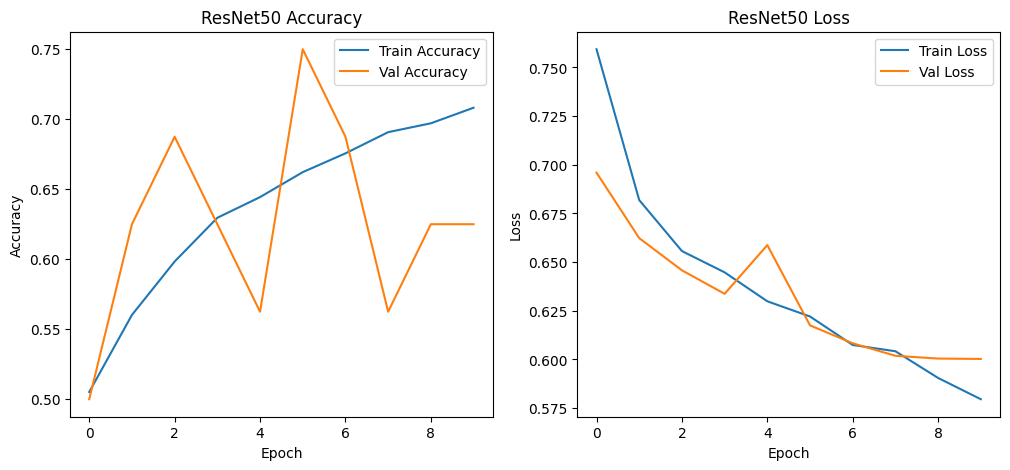

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function with your history object
plot_history(resnet_history, "ResNet50")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate ResNet model
def evaluate_model(model, test_data, name):
    print(f"\nEvaluating {name} on test data:")
    loss, acc = model.evaluate(test_data)
    print(f"Test Accuracy: {acc:.4f}")

    y_pred = (model.predict(test_data) > 0.5).astype(int).reshape(-1)
    y_true = test_data.classes

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

# Call the function
evaluate_model(resnet_model, test_data, "ResNet50")



Evaluating ResNet50 on test data:
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.5971 - loss: 0.6253
Test Accuracy: 0.7740
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step

Confusion Matrix:
[[132 102]
 [ 39 351]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.77      0.56      0.65       234
   PNEUMONIA       0.77      0.90      0.83       390

    accuracy                           0.77       624
   macro avg       0.77      0.73      0.74       624
weighted avg       0.77      0.77      0.76       624



In [ ]:
# CNN with Transformer Architecture
cnn_input = Input(shape=(img_height, img_width, 3))
x = Conv2D(32, (3,3), activation='relu')(cnn_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Reshape((-1, 128))(x)

attn = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = LayerNormalization()(x + attn)
ff = Dense(128, activation='relu')(x)
x = LayerNormalization()(x + ff)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

transformer_model = Model(inputs=cnn_input, outputs=output)
transformer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

In [ ]:
# Train CNN with Transformer
transformer_history = transformer_model.fit(
train_data,
epochs=10,
validation_data=val_data,)

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 156s 454ms/step - accuracy: 0.6859 - loss: 0.6784 - val_accuracy: 0.8125 - val_loss: 0.4618
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 147s 452ms/step - accuracy: 0.7740 - loss: 0.4139 - val_accuracy: 0.7500 - val_loss: 0.6569
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 147s 452ms/step - accuracy: 0.8072 - loss: 0.3924 - val_accuracy: 0.6250 - val_loss: 0.6754
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 148s 453ms/step - accuracy: 0.8303 - loss: 0.3695 - val_accuracy: 0.6875 - val_loss: 0.6049
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 148s 454ms/step - accuracy: 0.8261 - loss: 0.3494 - val_accuracy: 0.6875 - val_loss: 0.6710
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 149s 456ms/step - accuracy: 0.8611 - loss: 0.3062 - val_accuracy: 0.6875 - val_loss: 0.8793
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 151s 464ms/step - accuracy: 0.8752 - loss: 0.2878 - val_accuracy: 0.7500 - val_loss: 0.6554
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 155s 475ms/step - accuracy: 0.8659 -

In [ ]:
# Plotting function
def plot_history(history, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

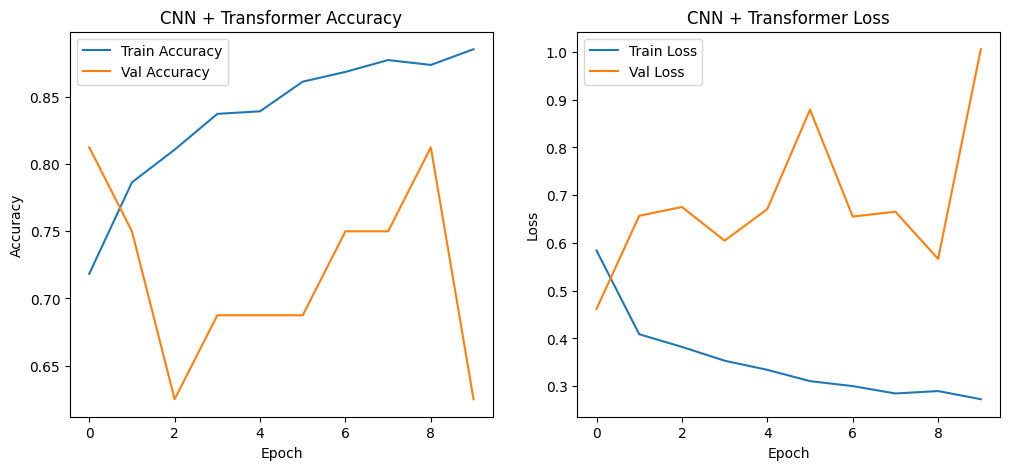

In [ ]:
# Plot for CNN with Transformer
plot_history(transformer_history, "CNN + Transformer")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluation function
def evaluate_model(model, test_data, name):
    print(f"\nEvaluating {name} on test data:")
    loss, acc = model.evaluate(test_data)
    print(f"Test Accuracy: {acc:.4f}")

    y_pred = (model.predict(test_data) > 0.5).astype(int).reshape(-1)
    y_true = test_data.classes

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

# Evaluate CNN with Transformer
evaluate_model(transformer_model, test_data, "CNN + Transformer")



Evaluating CNN + Transformer on test data:
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.6923 - loss: 0.7541
Test Accuracy: 0.7821
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step

Confusion Matrix:
[[145  89]
 [ 47 343]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.76      0.62      0.68       234
   PNEUMONIA       0.79      0.88      0.83       390

    accuracy                           0.78       624
   macro avg       0.77      0.75      0.76       624
weighted avg       0.78      0.78      0.78       624



20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step


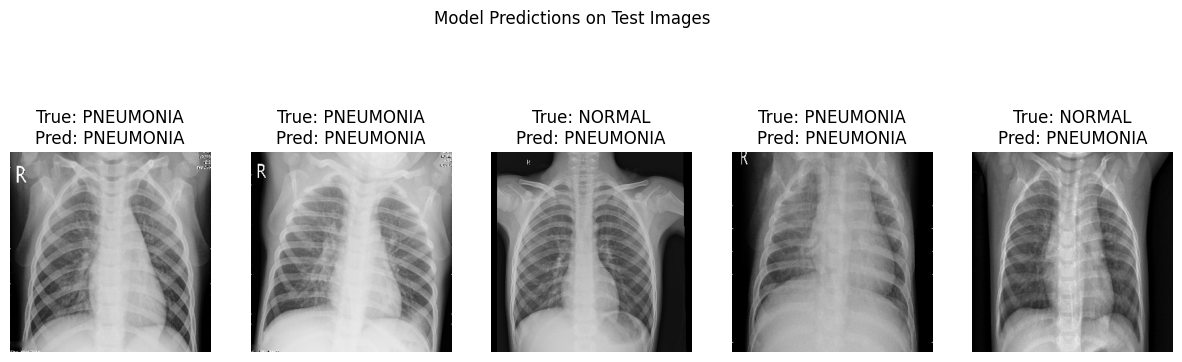

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Re-initialize test_data if needed to start from beginning
test_data.reset()

# Collect all images and labels
test_images, test_labels = [], []

# Loop through all batches
for _ in range(len(test_data)):
    img_batch, label_batch = next(test_data)
    test_images.extend(img_batch)
    test_labels.extend(label_batch)

# Convert to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels).reshape(-1)

# Get predictions from the model
preds = (transformer_model.predict(test_images) > 0.5).astype(int).reshape(-1)

# Get class names
class_names = list(test_data.class_indices.keys())

# Randomly select 5 images
random_indices = random.sample(range(len(test_images)), 5)

# Plot predictions
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[idx])
    true_label = class_names[int(test_labels[idx])]
    pred_label = class_names[int(preds[idx])]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.suptitle("Model Predictions on Test Images")
plt.show()
